In [62]:
import sys
import torch
from scipy.stats import wasserstein_distance
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0, 1'
sys.path.append('/extra/yadongl10/BIG_sandbox/SparseImageFlows/SMAF')
sys.path.append('/extra/yadongl10/BIG_sandbox/SparseImageFlows/Notebooks')

# from plot_utils import discrete_mass, discrete_pt, ChiSquareTest
import utils
import plot_utils
import multiscale_flows as multiscale
import imp
imp.reload(multiscale)

from utils import load_data_LAGAN

from plot_utils import discrete_mass, discrete_pt
import seaborn as sns
from scipy.stats import wasserstein_distance
import utils
import plot_utils
import pickle as pkl
import torch.nn as nn
import time

In [2]:
n = 36000
sg_t = load_data_LAGAN(subset='signal')[-n:]
bg_t = load_data_LAGAN(subset='background')[-n:]

(436333, 25, 25) (436333, 25, 25)
return signal
(436333, 25, 25) (436333, 25, 25)
return background


In [63]:
num_points = 100
np.linspace(0, 276, num_points)

array([  0.        ,   2.78787879,   5.57575758,   8.36363636,
        11.15151515,  13.93939394,  16.72727273,  19.51515152,
        22.3030303 ,  25.09090909,  27.87878788,  30.66666667,
        33.45454545,  36.24242424,  39.03030303,  41.81818182,
        44.60606061,  47.39393939,  50.18181818,  52.96969697,
        55.75757576,  58.54545455,  61.33333333,  64.12121212,
        66.90909091,  69.6969697 ,  72.48484848,  75.27272727,
        78.06060606,  80.84848485,  83.63636364,  86.42424242,
        89.21212121,  92.        ,  94.78787879,  97.57575758,
       100.36363636, 103.15151515, 105.93939394, 108.72727273,
       111.51515152, 114.3030303 , 117.09090909, 119.87878788,
       122.66666667, 125.45454545, 128.24242424, 131.03030303,
       133.81818182, 136.60606061, 139.39393939, 142.18181818,
       144.96969697, 147.75757576, 150.54545455, 153.33333333,
       156.12121212, 158.90909091, 161.6969697 , 164.48484848,
       167.27272727, 170.06060606, 172.84848485, 175.63

In [18]:
step = 276 / (num_points- 1)
step

2.787878787878788

In [14]:
x = np.array([1.2, 10.0, 12.4, 15.5, 22., 19.6])
bins = np.array([0, 5, 10, 15, 20])
loc = np.digitize(x,bins,right=False) - 1
bins[loc]
np.floor(x)

array([ 1., 10., 12., 15., 22., 19.])

In [60]:
def quantize(x, step):
    return step * np.floor(x / step + 0.5)

def get_entropy(image, num_grid):
    """ get the entropy list for every pixel of a set of images.
    """
    quantize_grid = np.linspace(0, 276, num_grid)
    step = 276 / (num_grid - 1)
    image = image.reshape(-1, 25 ** 2)
    image = quantize(image, step)

    prob = np.zeros((625, len(quantize_grid)))
    for i, point in enumerate(quantize_grid):
        prob[:, i] = np.sum(image == point, axis=0) / image.shape[0]
    entropy_matrix = np.where(prob > 0, -prob * np.log2(prob), np.zeros_like(prob))
    entropy_list = np.sum(entropy_matrix, axis=1)
    return entropy_list

entropy_list = get_entropy(sg_t, num_grid=277)
ind = np.argsort(entropy_list)[::-1]

/home/yadongl1/anaconda3/envs/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log2
  from ipykernel import kernelapp as app
/home/yadongl1/anaconda3/envs/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in multiply
  from ipykernel import kernelapp as app


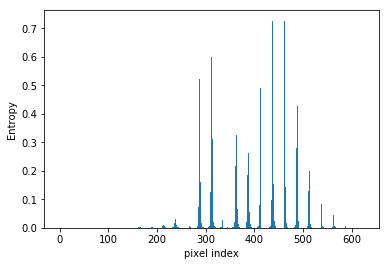

In [57]:
plt.bar(np.arange(625), entropy_list)
plt.ylabel('Entropy')
plt.xlabel('pixel index')

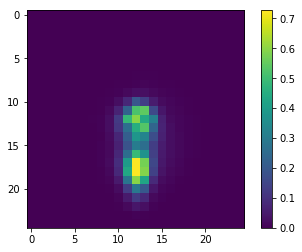

In [58]:
plt.imshow(entropy_list.reshape(25, 25))
plt.colorbar()

In [59]:
entropy_list[np.argsort(entropy_list)[::-1]]


array([7.26949430e-01, 7.24443969e-01, 5.98117974e-01, 5.98003989e-01,
       5.91399323e-01, 5.75259117e-01, 5.45521359e-01, 5.31307653e-01,
       5.21258239e-01, 4.90309435e-01, 4.85271631e-01, 4.55380086e-01,
       4.45221131e-01, 4.37187744e-01, 4.26987126e-01, 3.99891464e-01,
       3.81375773e-01, 3.71761631e-01, 3.26954817e-01, 3.13303918e-01,
       3.05685904e-01, 2.91457331e-01, 2.81218104e-01, 2.66911615e-01,
       2.63589350e-01, 2.62180286e-01, 2.38401513e-01, 2.28100893e-01,
       2.18513650e-01, 1.99753194e-01, 1.98403400e-01, 1.85641325e-01,
       1.70526672e-01, 1.61594162e-01, 1.54865634e-01, 1.41653982e-01,
       1.36613548e-01, 1.35728279e-01, 1.31763784e-01, 1.30497208e-01,
       1.24942103e-01, 1.23232860e-01, 1.16199204e-01, 9.64390232e-02,
       8.80021336e-02, 8.33848488e-02, 8.28205388e-02, 8.15841304e-02,
       8.03224442e-02, 7.87874115e-02, 7.33004170e-02, 7.24657473e-02,
       6.79043552e-02, 6.64173359e-02, 6.55395429e-02, 5.53044324e-02,
      

# load train model
1. load model 
2. generate 
3. compare metrics as (x, y) axis
4. plot 

In [ ]:
def load_model(model_dir)
    modules = []
    modules += [fnn.DiscreteSoftmaxMADE(num_inputs, num_hidden, num_cond_inputs,
                                          act=args.activation, num_latent_layer=args.latent)]
    model = fnn.FlowSequential(*modules)

    checkpoint = torch.load(model_dir + '/model_80.pt')
    model = nn.DataParallel(model).to('cuda')
    model.load_state_dict(checkpoint)
    model.to('cuda')

    model_core = modules[0]
    model_core = nn.DataParallel(model_core).to('cuda')
    return model_core


def transform(samples, ind):
    inverse_ind = []
    for i in range(625):
        inverse_ind.append(np.where(ind==i))
    inverse_ind = np.asarray(inverse_ind).squeeze()
    samples = samples[:, inverse_ind]
    return samples


def generate(model_core, num_batch, batchsize):
    """
    output: generated data
    """
    print('generate {} in {} batches'.format(num_batch* batchsize, num_batch))
    torch.manual_seed(123)
    print(torch.cuda.device_count())
    
    all_samples = np.zeros((num_batch*batchsize, 25, 25))
    with torch.no_grad():
        for i in range(num_batch):
            inputs = torch.tensor(image[i*batchsize:(i+1)*batchsize, :, :]).cuda().view(-1, 625)
            inputs, ind = utils.vector_spiral_perm(inputs, dim=25)

            start = time.time()
            samples = model_core(inputs, mode='inverse')
            print(samples.shape)
            dur = time.time() - start 
            print('generated the {}th batch using {} seconds'.format(i, dur))
            
            samples = transform(samples, ind)
            samples = samples.cpu().numpy().reshape(batchsize, 25, 25)
            all_samples[i*batchsize: (i+1)*batchsize] = samples
    return all_samples

def get_distance(image, samples, image_size):
    samples[samples < 0] = 0 
    pt_dist = wasserstein_distance(plot_utils.discrete_pt(image),
                                plot_utils.discrete_pt(np.asarray(samples.tolist()).reshape(-1, image_size, image_size)))
    mass_dist = wasserstein_distance(plot_utils.discrete_mass(image),
                               plot_utils.discrete_mass(np.asarray(samples.tolist()).reshape(-1, image_size, image_size)))
    print('Wasserstein distance Pt:', pt_dist)
    print('Wasserstein distance Mass:', mass_dist)
    return [pt_dist, mass_dist]

In [ ]:
######################################## main ########################################
image_size = 25
num_inputs = 625
num_samples = 1000
model_dir = '/extra/yadongl10/BIG_sandbox/SparseImageFlows_result/sg' +\
'/0304_multi_9_5_batch128_reshapenorm_GeLU_const_lr_400000train/lr_1e-4_act_GeLU_latent_5_spiral'
model_dir_list = [
    
]

def main(model_dir):
    model_core = load_model(model_dir)
    samples = generate(model_core, num_batch=1, batchsize = num_samples)
    pt_dist, mass_dist = get_distance(image[:num_samples], samples, image_size)
    return [pt_dist, mass_dist]


pt_mass_dist_list = [] 
for model_dir in model_dir_list:
    pt_mass_dist_list.append(main(model_dir))
    

### plot

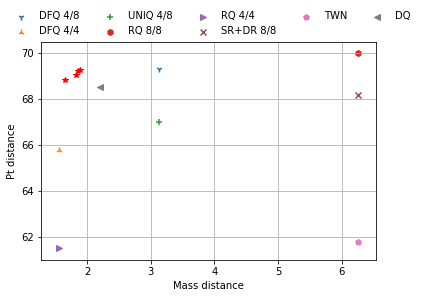

In [68]:
#%%
import matplotlib.pyplot as plt

label=['Baseline', 'DFQ 4/8', 'DFQ 4/4', 'UNIQ 4/8', 'RQ 8/8', 'RQ 4/4', 'SR+DR 8/8','TWN',  'DQ', 'DJPQ']
markers=['o','1','2','+','h','>','x','p','<','o','d','*','>','3']

n=len(pt_mass_dist_list)
for i in range(n):
    plt.scatter(pt_mass_dist_list[1], pt_mass_dist_list[0], marker=markers[i])
plt.legend(label[1:], loc='lower left', bbox_to_anchor= (-0.1, 1.01), ncol=5, 
            borderaxespad=0, frameon=False)

plt.ylabel('Pt distance')
plt.xlabel('Mass distance')
plt.grid()
# plt.savefig('resnet18_bop_vs_acc.eps',format='eps')
plt.show()
#%%
